# Machine Learning the Atom

This is to explore how one can deploy and optimize a neural network to minimize the energy of a physical system, particularly the hydrogen atom. We are going to begin with simpler examples first.

In [1]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
#from sklearn.model_selection import train_test_split

## Problem setup

First we will describe the problem. Let's start in 1D by solving a simple ODE.

In [2]:
# Model class
class ODESolver(nn.Module):
    """
     A simple neural network that fits an ODE solution
    """
    def __init__(self, width = 10):
        # super of what? Of this class, call the constructor of the parent class of ODESolver -> nn.Module
        super(ODESolver, self).__init__() 
        self.myNet = nn.Sequential(
            nn.Linear(1,width), #Entry point, 1D function
            nn.Tanh(),       #Activation function
            nn.Linear(width,width),
            nn.Tanh(),
            nn.Linear(width,1) # Output layer
        )
    
    # forwards propagate in the network
    def forward(self, x):
        return self.myNet(x) 

In [55]:
# Custom loss function for unsupervised learning
def lossFunction(model : nn.Module, x : torch.Tensor):

    x.requires_grad = True
    prediction = model(x)
    dudx = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0]
    # True because higher order derivatives are going to be needed in backpropagation
    domain_loss = torch.linalg.vector_norm(dudx + prediction) 
    boundary_loss = (model(torch.tensor([[0.0]])) - 1) ** 2 #initial condition
    return domain_loss + boundary_loss
    

In [56]:
model = ODESolver(5)  # Initialize the model
#optimizer = torch.optim.LBFGS(model.parameters())  # LBFGS optimizer with lr = 1, needs special 'step' treatment
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Training loop
x_train = torch.linspace(0, 2, 100).view(-1,1) # reshapes the 1D tensor to a (N,1), to enable parallel calculation and proper model feeding
errors = []
epochs = 5000
freq = 100
for epoch in range(epochs+1):
    optimizer.zero_grad()  # Reset gradients
    loss = lossFunction(model, x_train)  # Compute loss
    errors.append(loss.item())
    loss.backward()  # Compute gradients
    optimizer.step()  # Update model parameters
    if epoch % freq == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}",end="\r")

Epoch 5000, Loss: 0.024568490684032448

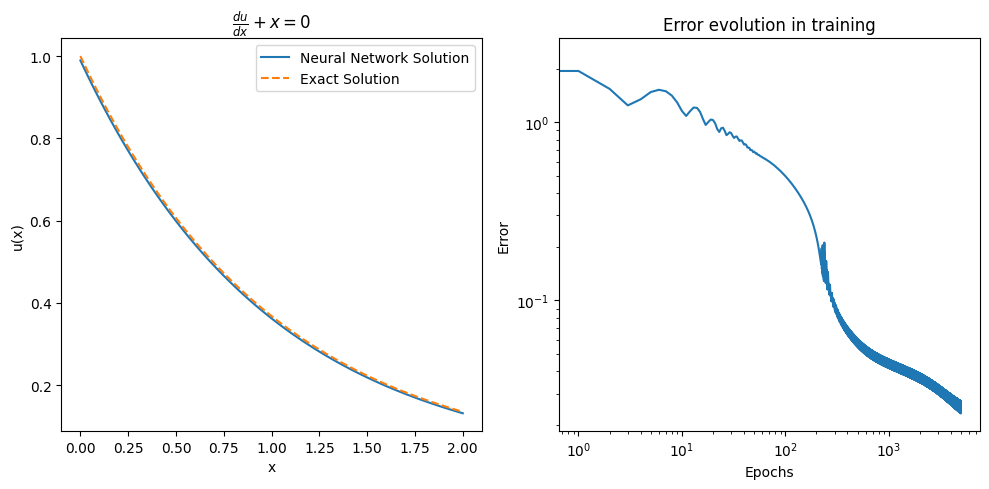

In [63]:
pred = model(x_train).detach().numpy()
np_x = x_train.detach().numpy()
exact = np.exp(-np_x)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.plot(np_x, pred, label="Neural Network Solution")
ax1.plot(np_x, exact, label="Exact Solution", linestyle="dashed")
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("u(x)")
ax1.set_title(r'$\frac{du}{dx} + x = 0$')

ax2.loglog(np.array(errors))
ax2.set_title("Error evolution in training")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Error")
plt.tight_layout()
plt.show()